In [1]:
import sys
sys.path.append('/home/lumargot/trachoma/src/py')

import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # put -1 to not use any

In [2]:
import os
import pandas as pd
import numpy as np 

import torch
import cv2

import matplotlib.pyplot as plt
import torchvision
import SimpleITK as sitk
from matplotlib.patches import Rectangle
from PIL import Image

In [4]:
df_all = pd.read_csv('/CMF/data/lumargot/trachoma/PoPP_Data/mtss/all_annotations.csv')

In [5]:
df_all

,Unnamed: 0.1,index,Unnamed: 0,cid,eye,lasteca12_pB,anyptt12,image path,patches path,class,label
0,0,0,0.0,11001,OS,0,1,img/11001_12Intra_os_postop.jpg,patches/11001_12Intra_os_postop.csv,TT,1
1,1,1,1.0,11007,OS,0,1,img/11007_12Intra_os_postop.jpg,patches/11007_12Intra_os_postop.csv,TT,1
2,2,2,2.0,11010,OS,0,1,img/11010_12Intra_os_postop.jpg,patches/11010_12Intra_os_postop.csv,TT,1
3,3,3,3.0,11011,OS,0,1,img/11011_12Intra_os_postop.jpg,patches/11011_12Intra_os_postop.csv,TT,1
4,4,4,4.0,11029,OD,0,1,img/11029_12Intra_od_postop.jpg,patches/11029_12Intra_od_postop.csv,TT,1
...,...,...,...,...,...,...,...,...,...,...,...
5061,5061,5061,NaN,15321,OS,0,0,img/15321_12Intra_os_postop.jpg,automatic_healthy_labels/15321_12Intra_os_post...,Healthy,0
5062,5062,5062,NaN,13105,OS,0,0,img/13105_12Intra_os_postop.jpg,automatic_healthy_labels/13105_12Intra_os_post...,Healthy,0
5063,5063,5063,NaN,15572,OS,0,0,img/15572_12Intra_os_postop.jpg,automatic_healthy_labels/15572_12Intra_os_post...,Healthy,0
5064,5064,5064,NaN,12066,OS,0,0,img/12066_12Intra_os_postop.jpg,automatic_healthy_labels/12066_12Intra_os_post...,Healthy,0


In [6]:
mnt = '/CMF/data/lumargot/trachoma/PoPP_Data/mtss'

In [14]:
mapping = {'Healthy':0, 'ECA':1, 'Entropion':2, 'Gap':3, 
           'overcorrection':4, 'Short Incision':5, 'TT': 6, 
           'Probable TT':7, 'Probable Epilation':8, 'Epilation':9, 'Fleshy':10}


In [32]:
import torch

In [ ]:
# torchvision.ops.nms

In [ ]:
x,y = df_i['x'], df

,Unnamed: 0,x,y,label
0,0,504,2229,Healthy
1,1,654,2153,Healthy
2,2,805,2078,Healthy
3,3,955,2033,Healthy
4,4,1105,1989,Healthy
5,5,1255,1977,Healthy
6,6,1406,1966,Healthy
7,7,1556,1990,Healthy
8,8,1707,2014,Healthy
9,9,1857,2074,Healthy


In [40]:
def compute_eye_bbx(seg, label=1, pad=0):

    shape = seg.shape
    
    ij = torch.argwhere(seg.squeeze() != 0)

    bb = torch.tensor([0, 0, 0, 0])# xmin, ymin, xmax, ymax

    bb[0] = torch.clip(torch.min(ij[:,1]) - shape[1]*pad, 0, shape[1])
    bb[1] = torch.clip(torch.min(ij[:,0]) - shape[0]*pad, 0, shape[0])
    bb[2] = torch.clip(torch.max(ij[:,1]) + shape[1]*pad, 0, shape[1])
    bb[3] = torch.clip(torch.max(ij[:,0]) + shape[0]*pad, 0, shape[0])
    
    return bb


In [49]:
row = row

In [52]:
row

Unnamed: 0.1                                      0
index                                             0
Unnamed: 0                                      0.0
cid                                           11001
eye                                              OS
lasteca12_pB                                      0
anyptt12                                          1
image path          img/11001_12Intra_os_postop.jpg
patches path    patches/11001_12Intra_os_postop.csv
class                                            TT
label                                             1
Name: 0, dtype: object

In [90]:
l_cid,l_label,l_class,l_eye,l_x, l_y = [], [],[],[],[],[]
l_filename,l_path = [], []

for idx, row in df_all.iterrows():
  cid = row['cid']
  eye = row['eye']
  image = row['image path']
  patches = row['patches path']

  df_i = pd.read_csv(os.path.join(mnt, patches))
  for idx, row in df_i.iterrows():
    x,y,label = row['x'], row['y'], row['label']

    if label == 'Wavy/ECA':
      label = 'ECA'

    if label not in mapping.keys():
      print(label)

    class_id = mapping[label]

    l_x.append(int(x))
    l_y.append(int(y))
    l_cid.append(cid)
    l_eye.append(eye)
    l_label.append(label)
    l_class.append(class_id)
    l_filename.append(image)
    l_path.append(patches)


df_all_patch = pd.DataFrame(data={'cid':l_cid, 
                                  'patch':l_path, 
                                  'eye':l_eye, 
                                  'label':l_label,
                                  'class':l_class,
                                  'x_patch':l_x,
                                  'y_patch':l_y,
                                  'filename':l_filename,
                                  })


df_all_patch['dataset'] = 'PoPP_Data'
df_all_patch['to_drop'] = 0

In [97]:
df_subject = df_all_patch[['filename']].drop_duplicates()

In [160]:
df_all_patch

,cid,patch,eye,label,class,x_patch,y_patch,filename,dataset,to_drop
0,11001,patches/11001_12Intra_os_postop.csv,OS,TT,6,1024,2812,img/11001_12Intra_os_postop.jpg,PoPP_Data,0
1,11001,patches/11001_12Intra_os_postop.csv,OS,TT,6,1114,2778,img/11001_12Intra_os_postop.jpg,PoPP_Data,0
2,11001,patches/11001_12Intra_os_postop.csv,OS,Healthy,0,1203,2764,img/11001_12Intra_os_postop.jpg,PoPP_Data,0
3,11001,patches/11001_12Intra_os_postop.csv,OS,Healthy,0,948,2855,img/11001_12Intra_os_postop.jpg,PoPP_Data,0
4,11001,patches/11001_12Intra_os_postop.csv,OS,Healthy,0,846,2903,img/11001_12Intra_os_postop.jpg,PoPP_Data,0
...,...,...,...,...,...,...,...,...,...,...
72514,12919,automatic_healthy_labels/12919_12Intra_os_post...,OS,Healthy,0,1556,1990,img/12919_12Intra_os_postop.jpg,PoPP_Data,0
72515,12919,automatic_healthy_labels/12919_12Intra_os_post...,OS,Healthy,0,1707,2014,img/12919_12Intra_os_postop.jpg,PoPP_Data,0
72516,12919,automatic_healthy_labels/12919_12Intra_os_post...,OS,Healthy,0,1857,2074,img/12919_12Intra_os_postop.jpg,PoPP_Data,0
72517,12919,automatic_healthy_labels/12919_12Intra_os_post...,OS,Healthy,0,2007,2134,img/12919_12Intra_os_postop.jpg,PoPP_Data,0


In [156]:
new_df = pd.DataFrame()
for idx,row in df_subject.iterrows():
  subject = row['filename']

  df_patches = df_all_patch.loc[ df_all_patch['filename'] == subject]

  img_path = os.path.join(mnt, row['filename'])
  seg_path = img_path.replace('img', 'seg').replace('.jpg', '.nrrd')
  if os.path.exists(seg_path):

    seg = torch.tensor(np.squeeze(sitk.GetArrayFromImage(sitk.ReadImage(seg_path)).copy())).to(torch.float32)
    img = torch.tensor(np.squeeze(sitk.GetArrayFromImage(sitk.ReadImage(img_path)).copy())).to(torch.float32)
    img = img.permute((2, 0, 1))
    img = img/255.0


    ## crop img within segmentation
    bbx_eye = compute_eye_bbx(seg, pad=0.05)
    img_cropped = img[:,bbx_eye[1]:bbx_eye[3],bbx_eye[0]:bbx_eye[2] ]
    seg_cropped = seg[bbx_eye[1]:bbx_eye[3],bbx_eye[0]:bbx_eye[2] ]
    pad = int(img_cropped.shape[1]/10)

    df_Healthy = df_patches[df_patches['label'] == 'Healthy'].copy().reset_index()
    df_other = df_patches[df_patches['label'] != 'Healthy'].copy().reset_index()

    bbx, classes = [], []
    if not df_Healthy.empty:
      for idx, irow in df_Healthy.iterrows():
        x,y,label,class_id = irow['x_patch'], irow['y_patch'], irow['label'], irow['class']

        class_idx =  torch.tensor(class_id).to(torch.long)

        cropped_x, cropped_y = x - bbx_eye[0], y -bbx_eye[1]

        # ensure coordinates in range
        box = torch.tensor([max((cropped_x-2*pad/3), 0),
                            max((cropped_y-5*pad/3), 0),
                            min((cropped_x+2*pad/3), img_cropped.shape[2]),
                            min((cropped_y+pad/3), img_cropped.shape[1])])


        bbx.append(box)
        classes.append(class_idx.unsqueeze(0))

      bbx = torch.stack(bbx)
      scores = torch.where(torch.stack(classes) ==0, 0.2, 1.0)
      indices = torchvision.ops.nms(bbx, scores[:,0], iou_threshold=0.3)

      new_df = pd.concat([new_df, df_Healthy.iloc[indices], df_other])
  else:
    new_df = pd.concat([new_df, df_Healthy.iloc[indices], df_other])

In [ ]:
# new_df.to_csv('/CMF/data/lumargot/trachoma/PoPP_Data/mtss/new_annotations_selected.csv')

In [165]:
new_df['label'].value_counts()

Healthy               52372
ECA                    3490
Probable TT            2623
TT                     2215
Probable Epilation      205
Gap                      58
Epilation                35
Fleshy                    3
Name: label, dtype: int64

In [162]:
x,y

(2157, 2233)

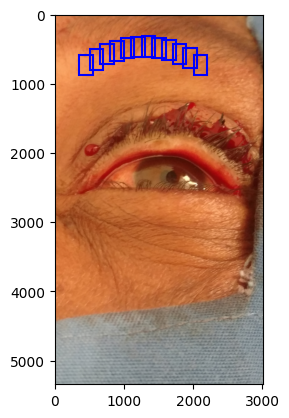

In [163]:
ax = plt.gca()
ax.imshow(img.permute(1,2,0))

for box in bbx:
  x1, y1, x2, y2 =box
  width, height = x2 - x1, y2 - y1

  rect = Rectangle((x1, y1), width, height, fill=False, color='b', linewidth=1.5)
  ax.add_patch(rect)

In [131]:
new_df['class'].value_counts()

0     58207
1      3140
7      2145
6      2027
8       201
9        82
3        48
10        3
Name: class, dtype: int64

In [ ]:
# df_all_patch.to_csv('/CMF/data/lumargot/trachoma/PoPP_Data/mtss/new_annotations_mtss.csv')

In [31]:
df_all_patch = pd.read_csv('/CMF/data/lumargot/trachoma/PoPP_Data/mtss/new_annotations_mtss.csv')

df_all_patch = df_all_patch.loc[df_all_patch['to_drop']==0]
df_all_patch[['class']].value_counts()

class
0        37556
2         5136
1         3817
3          326
dtype: int64

In [21]:
df_all.reset_index().to_csv('/CMF/data/lumargot/trachoma/PoPP_Data/mtss/all_annotations.csv')

In [16]:
df = pd.read_csv('/home/lumargot/trachoma/src/py/notebooks/healthy_done.csv')

In [8]:
df.sort_values(by='cid').reset_index().to_csv('/home/lumargot/trachoma/src/py/notebooks/healthy_done.csv')

In [11]:
df

,Unnamed: 0,image,eye,cid,class,outcome,seg
0,420,img/12008_12Intra_os_postop.jpg,OS,12008,0,Healthy,seg/12008_12Intra_os_postop.nrrd
1,421,img/12668_12Intra_od_postop.jpg,OD,12668,0,Healthy,seg/12668_12Intra_od_postop.nrrd
2,422,img/13158_12Intra_od_postop.jpg,OD,13158,0,Healthy,seg/13158_12Intra_od_postop.nrrd
3,424,img/15989_12Intra_od_postop.jpg,OD,15989,0,Healthy,seg/15989_12Intra_od_postop.nrrd
4,426,img/11049_12Intra_os_postop.jpg,OS,11049,0,Healthy,seg/11049_12Intra_os_postop.nrrd
...,...,...,...,...,...,...,...
5049,7354,img/15004_12Intra_os_postop.jpg,OS,15004,0,Healthy,seg/15004_12Intra_os_postop.nrrd
5050,7355,img/13220_12Intra_os_postop.jpg,OS,13220,0,Healthy,seg/13220_12Intra_os_postop.nrrd
5051,7356,img/12370_12Intra_od_postop.jpg,OD,12370,0,Healthy,seg/12370_12Intra_od_postop.nrrd
5052,7357,img/14154_12Intra_od_postop.jpg,OD,14154,0,Healthy,seg/14154_12Intra_od_postop.nrrd


In [ ]:
# df = pd.read_csv('/CMF/data/lumargot/trachoma/PoPP_Data/mtss/all_annotations.csv')

In [ ]:
df_tmp =

,Unnamed: 0,cid,eye,lasteca12_pB,anyptt12,image path,patches path
0,0,11001,OS,0,1,PoPP Annotations for MTSS\img\11001_12Intra_os...,PoPP Annotations for MTSS\Patches_nvarnado\110...
1,1,11007,OS,0,1,PoPP Annotations for MTSS\img\11007_12Intra_os...,PoPP Annotations for MTSS\Patches_nvarnado\110...
2,2,11010,OS,0,1,PoPP Annotations for MTSS\img\11010_12Intra_os...,PoPP Annotations for MTSS\Patches_nvarnado\110...
3,3,11011,OS,0,1,PoPP Annotations for MTSS\img\11011_12Intra_os...,PoPP Annotations for MTSS\Patches_nvarnado\110...
4,4,11029,OD,0,1,PoPP Annotations for MTSS\img\11029_12Intra_od...,PoPP Annotations for MTSS\Patches_nvarnado\110...
...,...,...,...,...,...,...,...
3030,3030,14369,OD,0,0,PoPP Annotations for MTSS\img\14369_12Intra_od...,lumargot\Patches_lucie\14369_12Intra_od_postop...
3031,3031,11488,OS,0,0,PoPP Annotations for MTSS\img\11488_12Intra_os...,lumargot\Patches_lucie\11488_12Intra_os_postop...
3032,3032,15827,OD,0,0,PoPP Annotations for MTSS\img\15827_12Intra_od...,lumargot\Patches_lucie\15827_12Intra_od_postop...
3033,3033,12884,OD,0,0,PoPP Annotations for MTSS\img\12884_12Intra_od...,lumargot\Patches_lucie\12884_12Intra_od_postop...


In [9]:
csv_healthy_subject = '/CMF/data/lumargot/trachoma/PoPP_Data/mtss/csv/mtss_healthy.csv'
mount_point= '/CMF/data/lumargot/trachoma/PoPP_Data/mtss/'


df = pd.read_csv(csv_healthy_subject)

In [10]:
df

,Unnamed: 0,image,eye,cid,class,outcome,seg
0,420,img/12008_12Intra_os_postop.jpg,OS,12008,0,Healthy,seg/12008_12Intra_os_postop.nrrd
1,421,img/12668_12Intra_od_postop.jpg,OD,12668,0,Healthy,seg/12668_12Intra_od_postop.nrrd
2,422,img/13158_12Intra_od_postop.jpg,OD,13158,0,Healthy,seg/13158_12Intra_od_postop.nrrd
3,424,img/15989_12Intra_od_postop.jpg,OD,15989,0,Healthy,seg/15989_12Intra_od_postop.nrrd
4,426,img/11049_12Intra_os_postop.jpg,OS,11049,0,Healthy,seg/11049_12Intra_os_postop.nrrd
...,...,...,...,...,...,...,...
5049,7354,img/15004_12Intra_os_postop.jpg,OS,15004,0,Healthy,seg/15004_12Intra_os_postop.nrrd
5050,7355,img/13220_12Intra_os_postop.jpg,OS,13220,0,Healthy,seg/13220_12Intra_os_postop.nrrd
5051,7356,img/12370_12Intra_od_postop.jpg,OD,12370,0,Healthy,seg/12370_12Intra_od_postop.nrrd
5052,7357,img/14154_12Intra_od_postop.jpg,OD,14154,0,Healthy,seg/14154_12Intra_od_postop.nrrd


In [3]:
def show_patches_from_polyfit(seg, step=20, show=True, img=None):

  bbx_eye = compute_eye_bbx(seg, pad=0)
  seg_cropped = seg[bbx_eye[1]:bbx_eye[3],bbx_eye[0]:bbx_eye[2] ]


  y, x = np.where(seg_cropped == 3)	

  z = np.polyfit(x, y, 3)
  poly = np.poly1d(z)

  x_axis = np.arange(bbx_eye[0], bbx_eye[2], step=step)
  y_axis = poly(x_axis)


  height = (bbx_eye[3] - bbx_eye[1])/10
  y_axis = y_axis + bbx_eye[1].numpy() #+ height.numpy()
  x_axis, y_axis = list(map(int,x_axis[1:-1])), list(map(int,y_axis[1:-1]))
  if show:

    fig = plt.figure()
    ax = fig.add_subplot()
    ax.imshow(img.permute(1,2,0))
    plt.plot(x_axis, y_axis)
    # plt.plot(x_axis, y_axis, 'bo')

    plt.xlabel("x - axis")
    plt.ylabel("y - axis")
    plt.show()

  return x_axis, y_axis

def compute_eye_bbx(seg, pad=0):

    shape = seg.shape
    
    ij = torch.argwhere(seg.squeeze() == 3)

    # ij = torch.argwhere(torch.isin(seg.squeeze(), torch.tensor([1, 2])))

    bb = torch.tensor([0, 0, 0, 0])# xmin, ymin, xmax, ymax

    bb[0] = torch.clip(torch.min(ij[:,1]) + shape[1]*pad, 0, shape[1])
    bb[1] = torch.clip(torch.min(ij[:,0]) + shape[0]*pad, 0, shape[0])
    bb[2] = torch.clip(torch.max(ij[:,1]) - shape[1]*pad, 0, shape[1])
    bb[3] = torch.clip(torch.max(ij[:,0]) - shape[0]*pad, 0, shape[0])
    
    return bb

def show_annotations(img, x, y, title):
    fig = plt.figure()
    plt.imshow(img)

    ax = fig.add_subplot()
    ax.imshow(img)
    plt.title(title)
    plt.plot(x, y, 'bo')
    plt.show()


In [5]:
data_out = '/CMF/data/lumargot/trachoma/PoPP_Data/'
# os.makedirs(data_out)

In [4]:
# df = pd.read_csv('healthy_patches.csv')
df = pd.read_csv('/CMF/data/lumargot/trachoma/new_csv/mtss_pret_combined_train_fold0_test.csv')

In [15]:
df = df.reset_index()

In [16]:
len(df)

2032

In [5]:
list_patches = []
for idx, row in df.iterrows():
  img_path = os.path.join(mount_point,row['image'])
  seg_path = os.path.join(mount_point,row['seg'])

  seg = torch.tensor(np.squeeze(sitk.GetArrayFromImage(sitk.ReadImage(seg_path)).copy())).to(torch.float32)
  img = torch.tensor(np.squeeze(sitk.GetArrayFromImage(sitk.ReadImage(img_path)).copy())).to(torch.float32)
  img = img.permute((2, 0, 1))
  img = img/255.0

  step = img.shape[-1]/15

  bbx_eye = compute_eye_bbx(seg, pad=0.01)
  bbx_eye[0]+=10
  bbx_eye[2]+=10
  seg_cropped = seg[bbx_eye[1]:bbx_eye[3],bbx_eye[0]:bbx_eye[2] ]
  # plt.imshow(seg_cropped)
  # plt.show()

  y, x = np.where(seg_cropped == 3)	

  z = np.polyfit(x, y, 3)
  poly = np.poly1d(z)

  x_axis = np.arange(bbx_eye[0], bbx_eye[2], step=step)
  y_axis = poly(x_axis)


  height = (bbx_eye[3] - bbx_eye[1])/10
  y_axis = y_axis + bbx_eye[1].numpy()
  x_axis, y_axis = list(map(int,x_axis[1:-1])), list(map(int,y_axis[1:-1]))

  fig = plt.figure()
  ax = fig.add_subplot()
  ax.imshow(img.permute(1,2,0))
  plt.plot(x_axis, y_axis, 'bo')

  plt.xlabel("x - axis")
  plt.ylabel("y - axis")
  plt.show()

  df_out  = pd.DataFrame(data={'x':x, 'y':y})
  df_out['label'] = 'Healthy'
  # out_file = os.path.join(data_out, os.path.basename(row['image'].replace('.jpg', '.csv')))
  # # df_out.to_csv(out_file)
  # list_patches.append(out_file)
  # plt.show()
  if idx == 5:
    break

NameError: name 'mount_point' is not defined

In [8]:
df['patches path'] = list_patches

In [123]:
len(df)

3086

In [11]:
low_bound = 0

In [13]:

df = df.loc[df['dataset']=='PoPP_Data'].reset_index()
df_subject = df['filename'].drop_duplicates()

In [14]:
df_subject

0       PoPP_Data/mtss/img/11010_12Intra_os_postop.jpg
14      PoPP_Data/mtss/img/11042_12Intra_od_postop.jpg
33      PoPP_Data/mtss/img/11038_12Intra_os_postop.jpg
46      PoPP_Data/mtss/img/11038_12Intra_od_postop.jpg
60      PoPP_Data/mtss/img/11042_12Intra_os_postop.jpg
                             ...                      
3514    PoPP_Data/mtss/img/16035_12Intra_os_postop.jpg
3533    PoPP_Data/mtss/img/16058_12Intra_od_postop.jpg
3550    PoPP_Data/mtss/img/15872_12Intra_od_postop.jpg
3565    PoPP_Data/mtss/img/15078_12Intra_os_postop.jpg
3575    PoPP_Data/mtss/img/14190_12Intra_os_postop.jpg
Name: filename, Length: 232, dtype: object

In [ ]:
for idx, row in df.iterrows():
  print(idx)
  subject = df_subject.iloc[idx]
  img_path = os.path.join('/CMF/data/lumargot/trachoma/',subject)
  seg_path = img_path.replace('img', 'seg').replace('.jpg', '.nrrd')

  df_patches = df.loc[ df['filename'] == subject]
  new_x, new_y = df_patches['x_patch'], df_patches['y_patch']

  img = torch.tensor(np.squeeze(sitk.GetArrayFromImage(sitk.ReadImage(img_path)).copy())).to(torch.float32)
  img = img.permute((2, 0, 1))
  img = img/255.0

  img = np.squeeze(sitk.GetArrayFromImage(sitk.ReadImage(img_path)).copy())
    # csv_path = os.path.join(data_out, row['patches path'])
    
    # df_patches = pd.read_csv(csv_path)
    # x_axis = df_patches['x']
    # y_axis = df_patches['y']

    # new_x, new_y = create_new_points(x_axis, y_axis)
    
  
  plt.figure()
  # # plt.subplot(121)
  # plt.imshow(img)
  # plt.plot(x_axis, y_axis, 'bo')

  # plt.subplot(122)
  plt.imshow(img)
  plt.plot(new_x, new_y, 'bo')
  plt.show()

    # df_out  = pd.DataFrame(data={'x':new_x, 'y':new_y})
    # df_out['label'] = 'Healthy'
    # # print(df_out)
    # df_out.to_csv(csv_path)

    

In [ ]:
def create_new_points(x_axis, y_axis):
  new_xs = []
  new_ys = []
  num_points = len(y_axis)

  for i in range(1, num_points):
    # print(i-1, i, i+1)
    x1,x2 = x_axis[i-1], x_axis[i]
    y1,y2 = y_axis[i-1], y_axis[i]

    xs = np.linspace(x_axis[i-1], x_axis[i], 3, dtype=int)
    ys = np.linspace(y_axis[i-1], y_axis[i], 3, dtype=int)


    new_xs.append(x1)
    new_xs.append(xs[1])

    new_ys.append(y1)
    new_ys.append(ys[1])
  return new_xs, new_ys